<a href="https://colab.research.google.com/github/AHMEDHAMID123/image_regression/blob/main/image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image regression
- using BIWI head pose dataset
- The database contains 24 sequences acquired with a Kinect sensor. 20 people (some were recorded twice - 6 women and 14 men) were recorded while turning their heads, sitting in front of the sensor, at roughly one meter of distance.

 - For each sequence, the corresponding .obj file represents a head template deformed to match the neutral face of that specific person.

 - In each folder, two .cal files contain calibration information for the depth and the color camera, e.g., the intrinsic camera matrix of the depth camera and the global rotation and translation to the rgb camera.
  -For each frame, a _rgb.png and a _depth.bin files are provided, containing color and depth data. The depth (in mm) is already segmented (the background is removed using a threshold on the distance) and the binary files compressed (an example c code is provided to show how to read the depth data into memory).

  - The _pose.txt files contain the ground truth information, i.e., the location of the center of the head in 3D and the head rotation, encoded as a 3x3 rotation matrix.


In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

## Exploring the data

In [3]:
path.ls().sorted()[0].ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00369_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00426_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00132_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00348_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00014_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00255_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00390_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00254_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00393_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00163_pose.txt')...]

## Investigate the pose.txt files

In [6]:
with open(path.ls().sorted()[0].ls()[0], "r") as f:
  print(f.read())

0.996864 0.0576457 0.0542161 
-0.0217349 0.858201 -0.512853 
-0.0760921 0.510066 0.856763 

56.3529 83.7627 856.208 




## Checking the image files

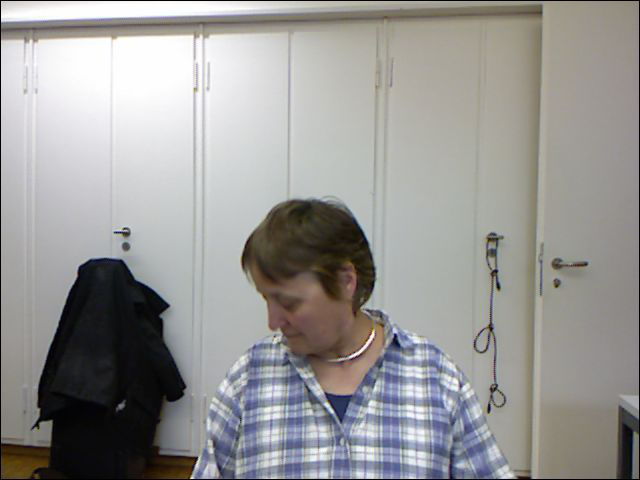

In [7]:
Image.open(path.ls().sorted()[0].ls()[1])

In [8]:
Image.open(path.ls().sorted()[2].ls()[1]).size

(640, 480)

During the training will resize the images, but will keep the same aspect ratio

## Building the dataloaders

### checking the image files and build function to get the labels and the images

In [43]:
files = get_image_files(path)
len(files)

15678

In [44]:
files[0]

Path('/root/.fastai/data/biwi_head_pose/05/frame_00426_rgb.jpg')

In [11]:
str(files[0])[:-7]

'/root/.fastai/data/biwi_head_pose/05/frame_00426_'

In [45]:
# funtion that extract the path for the image file and match it with its pose.txt
def label_files(x):
  return f"{str(x)[:-7]}pose.txt"

In [13]:
text_files = list(map(label_files, files))

In [47]:
#checking if the function is working correctly
with open(text_files[0], "r") as f:
  print(f.read())

0.780433 0.0818719 -0.619856 
0.00228092 0.99101 0.133766 
0.625236 -0.10581 0.77323 

128.515 27.1304 870.816 




Using numpy genfromtxt function to extract the numbers from the text files

In [18]:
np.genfromtxt(text_files[0])

array([[ 7.80433e-01,  8.18719e-02, -6.19856e-01],
       [ 2.28092e-03,  9.91010e-01,  1.33766e-01],
       [ 6.25236e-01, -1.05810e-01,  7.73230e-01],
       [ 1.28515e+02,  2.71304e+01,  8.70816e+02]])

In [17]:
np.genfromtxt(text_files[0], skip_header= 3)

array([128.515 ,  27.1304, 870.816 ])

In [21]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(label_files(f), skip_header=3)
    cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [48]:
# checking the function results
get_ctr(files[0])

tensor([396.3990, 256.6284])

In [23]:
dl = DataBlock(
    blocks = (ImageBlock, PointBlock),
               get_items = get_image_files,
               get_y = get_ctr,
               splitter = FuncSplitter(lambda x: x.parent.name == "13" or "14"),
               batch_tfms= aug_transforms(size = (240,320)))

In [24]:
dls = dl.dataloaders(path)

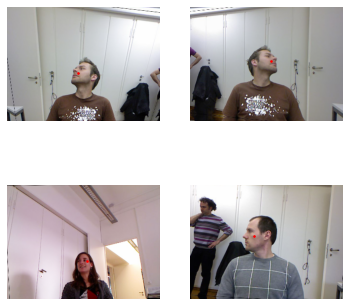

In [25]:
dls.show_batch(max_n= 4)

In [26]:
xb, yb = dls.one_batch()

In [27]:
yb[0:6]

TensorPoint([[[-0.4371,  0.0171]],

             [[-0.0706, -0.0650]],

             [[-0.0487,  0.0788]],

             [[ 0.0785,  0.3178]],

             [[ 0.0853,  0.0868]],

             [[ 0.0989,  0.2097]]], device='cuda:0')

In [28]:
learn = vision_learner(dls, resnet18, y_range= (-1,1))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

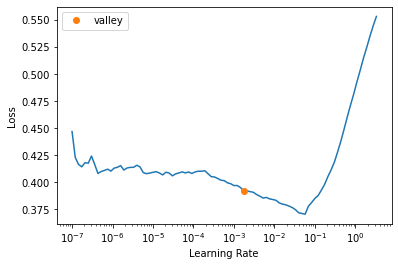

In [30]:
val_lr = learn.lr_find()

In [40]:
learn.fine_tune(3, base_lr= val_lr[0], freeze_epochs= 3)

epoch,train_loss,valid_loss,time
0,0.199759,0.067825,03:32
1,0.036394,0.008395,03:30
2,0.014171,0.000233,03:30


epoch,train_loss,valid_loss,time
0,0.004172,0.000131,03:36
1,0.002435,0.000243,03:37
2,0.001848,0.000152,03:35


 Using MSE as loss function we can use it as a metric , which corresponding to the average coordinates prediction error. And so our model has aroud$\sqrt {0.0001}$ error rate = 0.01.

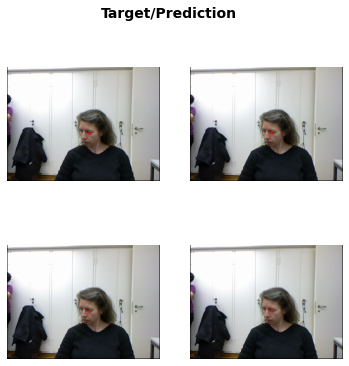

In [49]:
learn.show_results(nrows = 2, max_n = 4)

This model is working as a very good baseline model that we can imporve letter on using deeper arch, more advanced data augmnetation techniques and in addition to that we can also explore discriminative Learning rates

In [41]:
learn.summary()

Sequential (Input shape: 64 x 3 x 240 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 120 x 160 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 60 x 80   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      